In [1]:
import os
os.chdir("..")

In [2]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision import transforms

from datasets import SimpleVideoDataset
from models import FrameEncoder

/Users/aligarjani/Desktop/coview/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = SimpleVideoDataset("./data/Sintel_frames", index_slice=(314, 424), transform=transform)
# dataset = SimpleVideoDataset("./data/Sintel_frames", index_slice=(230, 260), transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=5, shuffle=True)

In [4]:
EPOCHS = 100
LR = 1e-4
device = "cpu"
print_every = -1
save_every = 20

encoder = FrameEncoder()
optimizer = torch.optim.Adam(encoder.parameters(), lr=LR)

def train_one_epoch(encoder, dataloader, optimizer, device, epoch):
    encoder.train()
    total_loss = []
    for step, (images, frame_ids) in enumerate(dataloader):
        images = images.to(device).unsqueeze(0)
        frame_ids = frame_ids.to(device).unsqueeze(0)
        _, loss = encoder(images, frame_ids, return_loss=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if print_every != -1 and step % print_every == 0:
            print(f"Loss at step {step} of epoch {epoch}: {loss.item()}")
        total_loss.append(loss.item())
    return total_loss
        
for epoch in range(EPOCHS):
    loss = train_one_epoch(encoder, dataloader, optimizer, device, epoch)
    print(f"Average loss at epoch {epoch}: {sum(loss) / len(loss)}")
    if epoch % save_every == 0 or epoch == EPOCHS - 1:
        torch.save(encoder.state_dict(), f"checkpoints/encoder_{epoch}.pth")


Average loss at epoch 0: 0.40440149432834005
Average loss at epoch 1: 0.2775431168265641
Average loss at epoch 2: 0.2952468881121604
Average loss at epoch 3: 0.17464260671113152
Average loss at epoch 4: 0.3389865332082991
Average loss at epoch 5: 0.08799569285474718
Average loss at epoch 6: 0.1359162155276863
Average loss at epoch 7: 0.3021694562630728
Average loss at epoch 8: 0.20406687539070845
Average loss at epoch 9: 0.3576927110552788
Average loss at epoch 10: 0.1691168500110507
Average loss at epoch 11: 0.10130562516859243
Average loss at epoch 12: 0.08526524762589816
Average loss at epoch 13: 0.14416900929018084
Average loss at epoch 14: 0.12789312022505328
Average loss at epoch 15: 0.23292904999107122
Average loss at epoch 16: 0.2555892389887404
Average loss at epoch 17: 0.32917659543454647
Average loss at epoch 18: 0.21458468679338427
Average loss at epoch 19: 0.2576069400529377
Average loss at epoch 20: 0.116375516789617


KeyboardInterrupt: 

In [ ]:
encoder = FrameEncoder()
encoder.load_state_dict(torch.load("checkpoints/run-2/encoder_99.pth"))
scratch_encoder = FrameEncoder(pretrained=False)

In [7]:
dataloader = DataLoader(dataset=dataset, batch_size=15, shuffle=False)
images, frame_ids = next(iter(dataloader))

In [18]:
embeddings = encoder.backbone.forward_features(images)[:,1:]
scratch_embeddings = scratch_encoder.backbone.forward_features(images)[:,1:]

def get_pca(embeddings):
    low_dim_embeddings = []
    for emb in embeddings:
        pca = PCA(n_components=3)
        pca.fit(emb)
        emb = pca.transform(emb)
        low_dim_embeddings.append(emb)
    return low_dim_embeddings

pca = get_pca(embeddings.detach().cpu().numpy())
scratch_pca = get_pca(scratch_embeddings.detach().cpu().numpy())

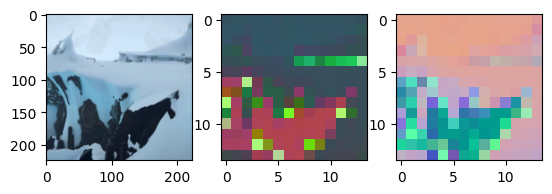

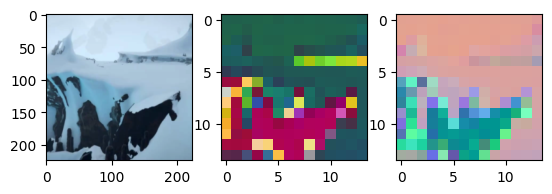

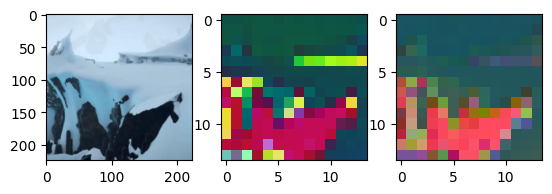

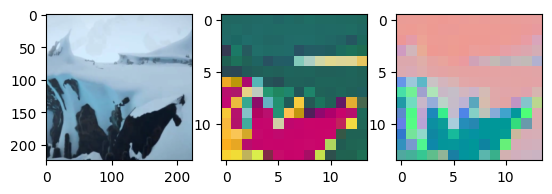

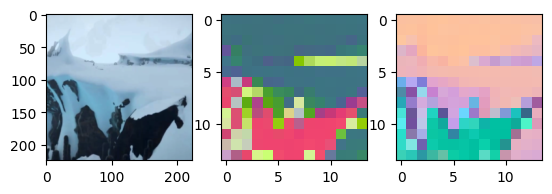

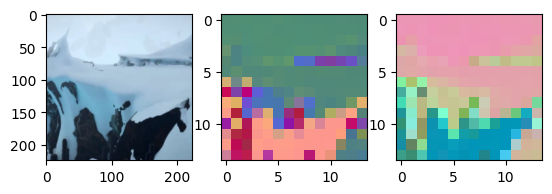

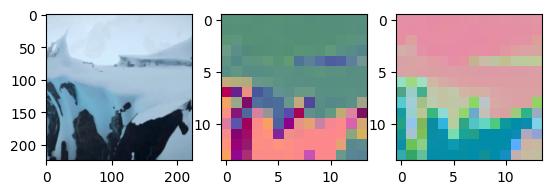

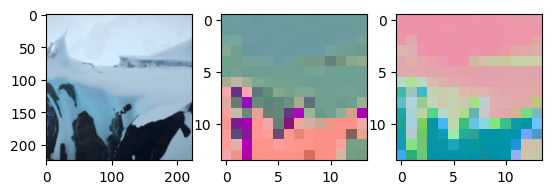

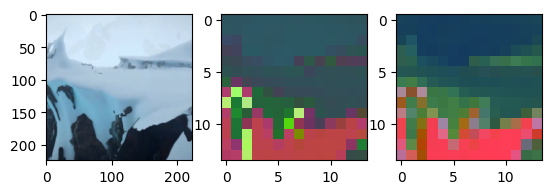

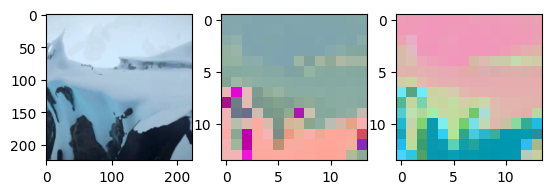

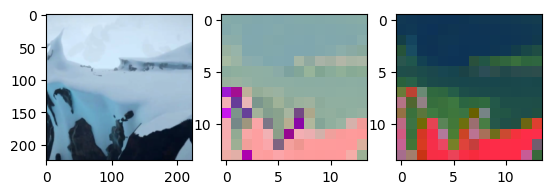

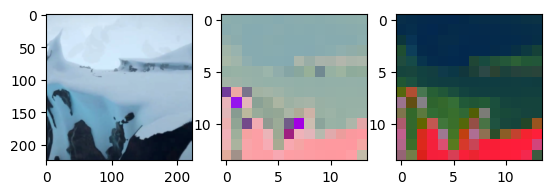

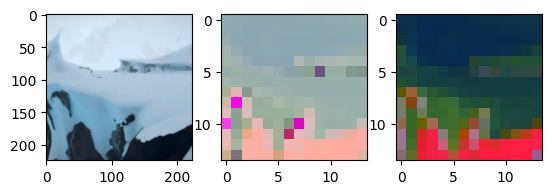

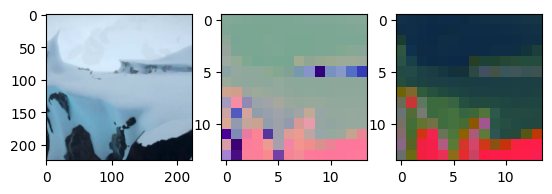

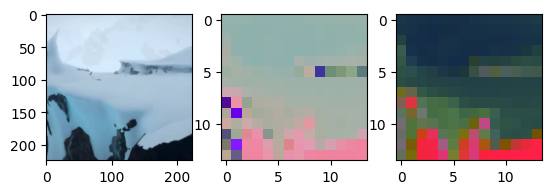

In [19]:
for p, sp, img in zip(pca, scratch_pca, images):
    p = p.reshape(14, 14, 3)
    p = (p - p.min()) / (p.max() - p.min())
    sp = sp.reshape(14, 14, 3)
    sp = (sp - sp.min()) / (sp.max() - sp.min())
    fig, ax = plt.subplots(1, 3)
    img = img.permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    ax[0].imshow(img)
    ax[1].imshow(p)
    ax[2].imshow(sp)
    plt.show()

In [14]:
attention = encoder.get_cls_attention_from_last_layer(images)
scratch_attention = scratch_encoder.get_cls_attention_from_last_layer(images)


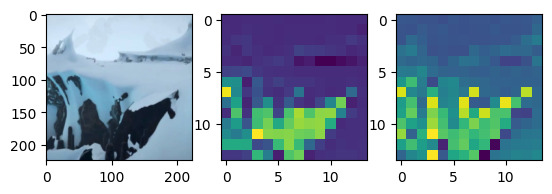

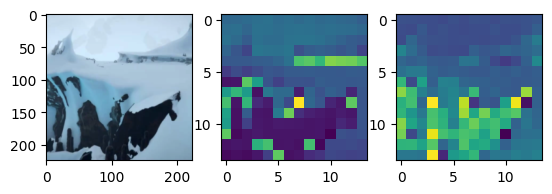

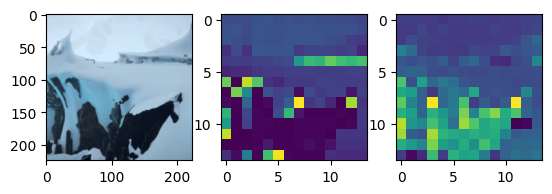

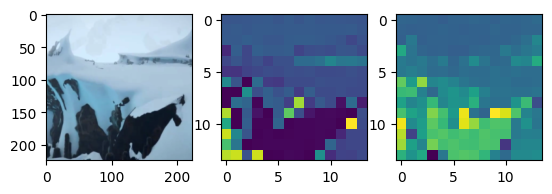

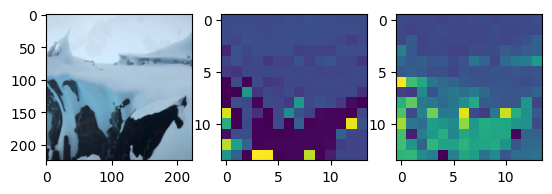

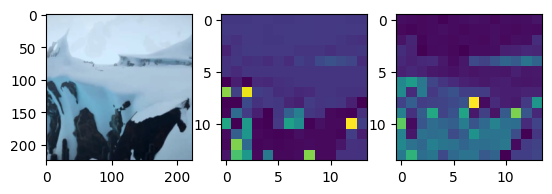

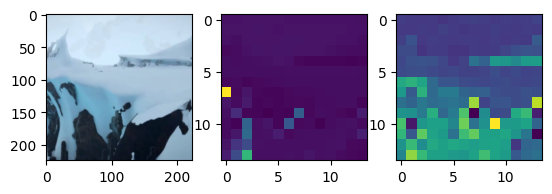

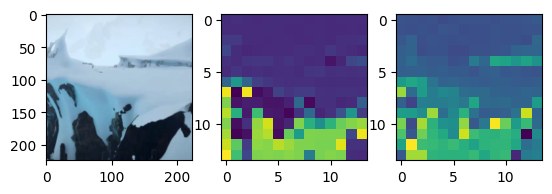

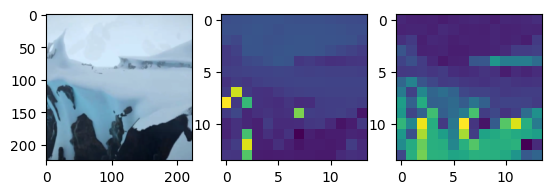

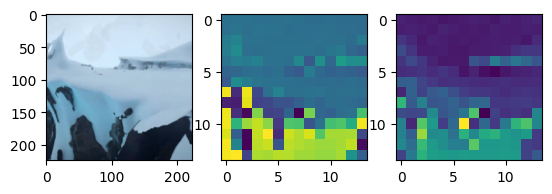

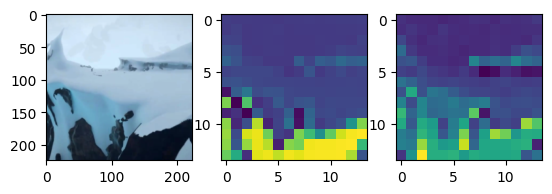

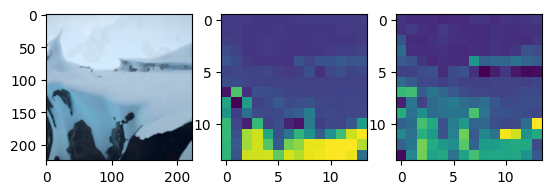

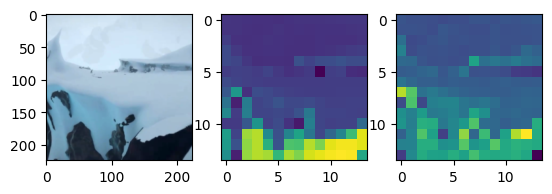

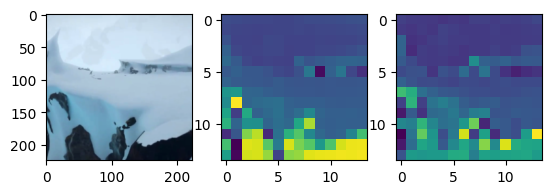

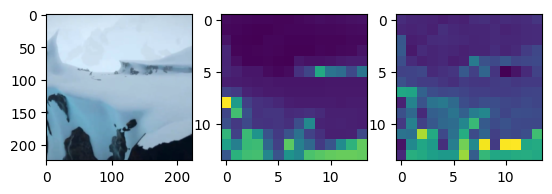

In [17]:
for attn, satn, img in zip(attention, scratch_attention, images):
    attn = attn.detach().cpu().numpy()
    attn = attn.mean(axis=0)
    attn = attn.reshape(14, 14)
    attn = (attn - attn.min()) / (attn.max() - attn.min())
    satn = satn.detach().cpu().numpy()
    satn = satn.mean(axis=0)
    satn = satn.reshape(14, 14)
    satn = (satn - satn.min()) / (satn.max() - satn.min())
    img = img.permute(1, 2, 0)
    img = (img - img.min()) / (img.max() - img.min())
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(img)
    ax[1].imshow(attn)
    ax[2].imshow(satn)
    plt.show()
